In [1]:
import math
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.plot
import shapely

import unrasterize
%matplotlib inline

## Introduction to unrasterize

This notebook outlines the basic uses of the `unrasterize` library.

### Source data

The data we'll use is 2015 United Nations adjusted population data for Belize at the 100 meter resolution. This data comes from [WorldPop.org](www.worldpop.org) and is generously provided under [the Creative Commons 4.0 license](https://creativecommons.org/licenses/by/4.0/).

### Parameters

We'll use the `WindowedUnrasterizer` class for this demonstration. This class makes all pixel selections within individual windows of the raster data (in this case, 128x128 blocks of pixels). For this reason, the class is highly memory efficient since it never has to hold an entire raster band in memory. This feature also means that it can operate in parallel, reducing computation times.

The `WindowedUnrasterizer` has the following parameters:
- `mask_width`: The number of pixels around an already selected pixel in which a new pixel will not be chosen. 
    - In the following example, this number is 10, indicating a minimum spacing of 10 pixels * 100 m / pixels = 1 km between adjacent pixels in the same raster window.
- `threshold`: The value in the raster data below which points will not be chosen. 
    - In this case, the threshold of 0.2 indicates that points estimated to have fewer than 0.2 people per 100m x 100m pixel will not be selected.

In [2]:
raster_path = '../data/Belize/BLZ_ppp_v2b_2015_UNadj.tif'
raster_data = rasterio.open(raster_path)
unrasterizer = unrasterize.WindowedUnrasterizer(mask_width=10, threshold=0.2)

### Selecting representative pixels
Each of the unrasterizer classes has the method `select_representative_pixels`, which fits the unrasterizer object to the provided raster dataset. The `WindowedUnrasterizer` allows for the determination of the window shape in calls to this method. In general, larger windows will be use more memory and take more computation time, but may yield more accurate results.

After pixels have been selected, calling `to_geojson` or `to_geopandas` on the unrasterizer produces a GeoJSON feature collection or GeoDataFrame. 

In [3]:
unrasterizer.select_representative_pixels(raster_data)
gdf = unrasterizer.to_geopandas(value_attribute_name='population', crs=raster_data.crs)
gdf.head(5)

,geometry,population
0,POINT (-89.12172829282866 17.17087061509331),300.544342
1,POINT (-89.14172749282866 17.07170791509331),684.482605
2,POINT (-89.13339449282866 17.07504111509331),730.973999
3,POINT (-89.13339449282866 17.06670811509331),704.010254
4,POINT (-89.14256079282866 17.06337491509331),486.696014


Let's use `GeoPandas` to visualize the selected points in context of the boundaries of Belize and compare them to the raw raster data visualized using `rasterio.plot.show`.

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
belize = world[world['name'] == 'Belize']

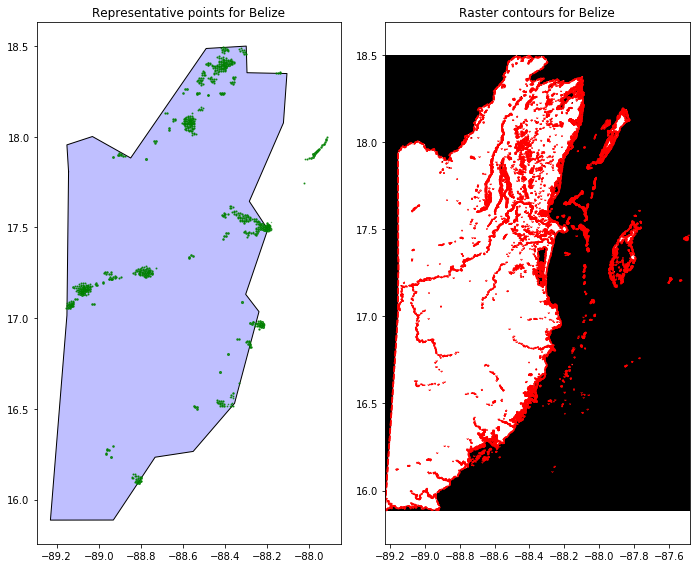

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
lims = plt.axis('equal')

belize.plot(ax=axes[0], color='b', alpha=0.25)
for point, pop in zip(gdf['geometry'], gdf['population']):
    gpd.plotting.plot_point(ax=axes[0], pt=point, markersize=math.log(pop, 5) / 2, color='green', alpha=0.8)
axes[0].set_title('Representative points for Belize')

band = raster_data.read(1)
transform=raster_data.transform

rasterio.plot.show((raster_data, 1), cmap='Greys_r', interpolation='none', ax=axes[1])
rasterio.plot.show((raster_data,1), contour=True, contour_label_kws={}, ax=axes[1], alpha=0.5)
axes[1].set_title('Raster contours for Belize')

plt.tight_layout()

Finally, let's compare our results to Nasa's Socioeconomic Data and Applications Center (SEDAC) population density map (provided under [the Creative Commons 3.0 license](https://creativecommons.org/licenses/by/3.0/)):

In [6]:
from IPython.display import Image
Image(
    url='http://sedac.ciesin.columbia.edu/downloads/maps/grump-v1/grump-v1-population-density/blzdens.jpg',
    width=600,
)